In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import scipy.linalg as la
import scipy.sparse as sparse
from scipy.sparse.linalg import LinearOperator
from scipy.fft import fft, ifft, fft2, ifft2, fftfreq
from scipy.optimize import minimize
from sklearn import datasets
from scipy.stats import multivariate_normal, norm
from scipy.signal import butter, lfilter, freqz, cheby1, sosfilt

In [2]:
class Op:
    def __init__(self, fun, jac, shape):
        self.eval = fun
        self.jac = jac
        self.shape = shape

def objective_1D(z, y, A, G, w=1, lmbda = 0):
    '''
    LS objective
        (0.5)*\|A(G(z)) - y\|_2^2 + 0.5*lmbda**2*\|w*z\|_2^2
    
    input

        w - option to put in more variation like Tikhonov?

    '''
    # to do implement size checks for A, z, G
    k  = len(z)//2
    zc = z[:k] + 1j*z[k:]

    # evaluations of G
    xc = G.eval(zc)
    Dx = G.jac(zc)

    # directly modifying does not work
    #xc = butter_lowpass_filter(xc,0.2, 1, order = 6)
    #min_val = np.min(np.abs(xc))
    #xc = xc + min_val + 0.1

    # evaluations of A
    yp = A.eval(xc)
    Dy = A.jac(xc)

    # compute value and gradient least squares
    val    = (0.5)*np.linalg.norm(yp - y)**2 + (0.5*lmbda**2)*np.linalg.norm(w*zc)**2
    gradc   = Dx.H(Dy.H@(yp - y)) + (lmbda**2)*(w*w)*zc

    grad  = np.concatenate((np.real(gradc), np.imag(gradc)))

    return val, grad

def reconstruct(xtrue, A, G, w=1, sigma=0, lmbda=0):
    # sizes
    m,n = A.shape
    n,k = G.shape
    
    # generate data
    yobs  = A.eval(xtrue) + sigma*np.random.randn(m)

    # inference
    result = minimize(objective_1D, x0=np.ones(2*k), args=(yobs, A, G, w, lmbda), method='L-BFGS-B', jac=True)
    
    # extract complex values
    zhat = result.x[:n] + 1j*result.x[n:]
    
    # correct global phase 
    phi = np.mean(np.angle(xtrue/zhat))
    zhat_corr = np.exp(1j*phi)*zhat
    
    # relative error
    error = np.linalg.norm(zhat_corr - xtrue)/np.linalg.norm(xtrue)
    
    # return
    return error, zhat_corr

In [3]:
def MaskedFourier_1D(M):
    '''
    Masked 1D fourier transform as a linear operator.

    input:
        M - 2D array of size n x m containing m windows of length n
    
    output:
        A - linear operator representing the masked Fourier transforms

    '''
    nx = M.shape[0] # length of window
    mx = M.shape[1] # number of windows

    mv  = lambda x : fft(M*x[:, None], axis=0).flatten()
    rmv = lambda y: np.sum(ifft(y.reshape((nx, mx)), axis=0) * np.conj(M), axis=1).flatten()
    
    A = LinearOperator((nx*mx, nx), matvec=mv, rmatvec = rmv)

    return A

In [4]:
# 1D ambiguity function
def Ambiguity(phi,m): #for now, ignore specific frequency component n and compute all
    '''
    input:
        phi - signal of length L
        m - shift of the signal
    output:
        Fourier vector of the signal multiplied by its conjugate shift
    '''
    shift_phi = np.conjugate(np.roll(phi,m))
    return fft(phi*shift_phi)

In [5]:
def block_signal(length,starts,heights,widths):
    '''
    input:
        lentgh signal, start (integer index), height, width (integer ndices)
    '''
    nsamples = len(starts)
    signals = np.zeros((nsamples, length))

    for i in range(nsamples):
        start = int(starts[i])
        width = int(widths[i])
        height = heights[i]
        end = min(start + width, length)  # Ensure block stays within bounds
        signals[i, start:end] = height
        
    return signals

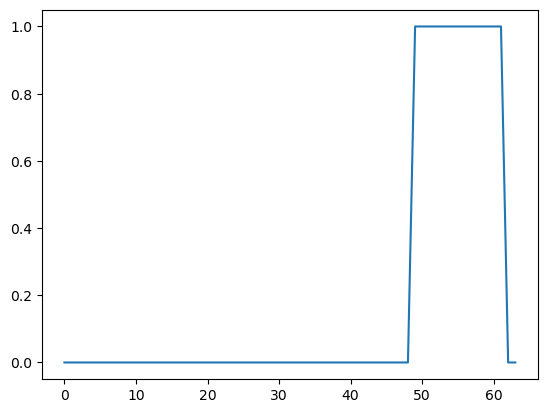

In [6]:
# create data set of a block signal with threshold delta bounded away from 0
delta = 0.1
nsamples = 180
n = 64
nx = int(np.sqrt(n))

heights = np.ones(nsamples)
starts = np.random.randint(0,n-2,nsamples)
widths = np.random.randint(1,n/2,nsamples)
X = block_signal(n,starts,heights,widths)

domain = np.linspace(0,63,64)
plt.figure()
plt.plot(domain,X[20,:])
plt.show()

-0.31347437754127344
0.1


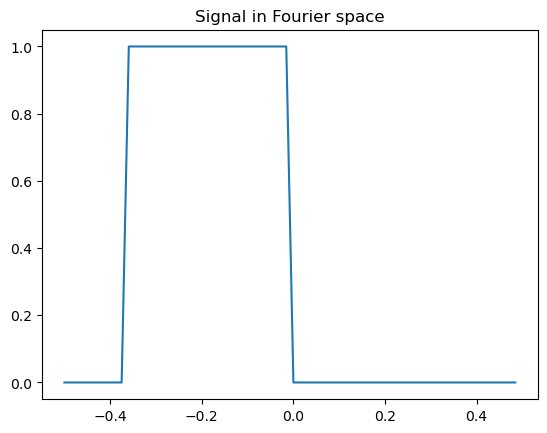

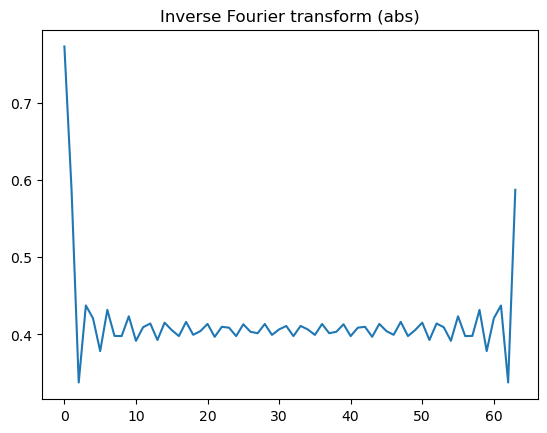

In [7]:
# use bandlimiting in frequency space (using real part, such that time signal has a real and imaginary part)
Y = ifft(X)
min_value = np.real(Y.min())
print(min_value)
Y = Y + delta + abs(min_value)

print(np.real(Y.min())) # test delta threshold

# plot random index
jndex = 10
amplitudes_X = abs(X[jndex,:])
k = fftfreq(64,1)
sorted_indices = np.argsort(k)
k = k[sorted_indices]
amplitudes_X = amplitudes_X[sorted_indices]

plt.figure()
plt.title("Signal in Fourier space")
plt.plot(k,amplitudes_X)
plt.show()

plt.figure()
plt.title("Inverse Fourier transform (abs)")
plt.plot(np.linspace(0,n-1,n),np.abs(Y[jndex,:]))
plt.show()

Min. value of ambiguity function of a random mask is  0.02956537376674105
The value of c is 4364.891864200112
Lowest threshold of the ambiguity function is 0.00022910075005563854
The mask with the lowest ambiguity threshold is 50


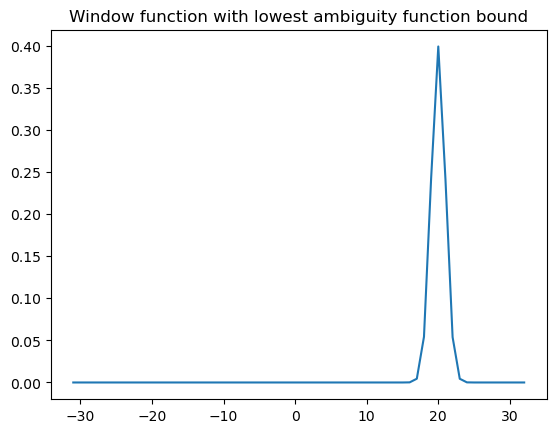

In [8]:
# create window function/mask
mx = 100

domain = np.linspace(-31,32,64)

# describes mx window functions of length n
windows = np.zeros((n,mx))
mu = np.random.uniform(-31,32,100)
windows = norm.pdf(domain[:, np.newaxis], mu, 1) # do not use a high variance, leads to small values ambiguity function

# make into n x n x mx matrix
M = np.zeros((n,n,mx))
for i in range(mx):
    M[:,:,i] = np.diag(windows[:,i])

# ambiguity of windows
mask_test = Ambiguity(windows[:,99], 1)
print("Min. value of ambiguity function of a random mask is ", abs(mask_test).min())

c = 0
for i in range(2):
    for j in range(mx): 
        mask_test = Ambiguity(windows[:,j], i)
        temp_max = 1/abs(mask_test).min()
        if temp_max > c:
            c = temp_max
            remember_mask_index = j
print("The value of c is", c)
print("Lowest threshold of the ambiguity function is", 1/c)
print("The mask with the lowest ambiguity threshold is", remember_mask_index)

plt.figure()
plt.plot(domain,windows[:,remember_mask_index])
plt.title("Window function with lowest ambiguity function bound")
plt.show()

In [9]:
# naive filter matrix version
def cut_off_matrix(n, highcut):
    k = fftfreq(n,1)
    Id = np.eye(n)
    cut_off = np.where((k < -highcut ) | (k > highcut))[0]
    Id[cut_off,:] = 0
    return Id

In [10]:
vector = np.ones(10)
transform = ifft(fft(vector))
print(vector)
print(transform)

F = fft(np.eye(10))
Fstar = (1/10)*np.conj(F).T #ifft(np.eye(10))
print(Fstar @ F @ vector)

F2 = la.dft(10, scale='sqrtn')
Fstar2 = np.conj(F2).T
print(Fstar2 @ F2 @ vector)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j]
[1.+0.00000000e+00j 1.-4.16333634e-17j 1.-8.32667268e-17j
 1.+8.32667268e-17j 1.+4.16333634e-17j 1.+0.00000000e+00j
 1.-4.16333634e-17j 1.-8.32667268e-17j 1.+8.32667268e-17j
 1.+4.16333634e-17j]
[1.-5.13465493e-16j 1.-4.51463405e-16j 1.-2.47975071e-16j
 1.-1.43329864e-16j 1.+5.89379606e-17j 1.+4.30084867e-17j
 1.+1.21788607e-16j 1.+3.16747459e-16j 1.+3.78635706e-16j
 1.+4.37115615e-16j]


##### Make operators

In [19]:
# prior parameters
m = mx * n
delta = 0.1

MF = MaskedFourier_1D(windows)
Afun = lambda x : np.abs(MF@x)**2
Ajac = lambda x : LinearOperator((m, n), matvec=lambda z : 2*(MF@x)*np.conj(MF@np.conj(z)), rmatvec=lambda z : 2*(MF.H@((MF@x)*z)))

A    = Op(fun = Afun, jac = Ajac, shape=(m,n))

def min_v_conj(z):
    k = np.argmin(np.abs(z))
    if z[k] == 0:
        v_k = 0  # Avoid division by zero
    else:
        v_k = z[k] / np.abs(z[k]) * np.sum(z)
    v = np.zeros_like(z)
    v[k] = v_k
    
    return v

def min_v(z):
    k = np.argmin(np.abs(z))
    if z[k] == 0:
        v = np.zeros_like(z)
        return v  
    else:
        v_k = (z[k]**2) / np.abs(z[k])
    v = v_k * np.ones_like(z)
    
    return v

# I 
I   = Op(fun = lambda z : z, jac = lambda z: LinearOperator((n, n), matvec = lambda z : z, rmatvec = lambda z : z), shape=(n,n))

# G threshold
#Gfun = lambda z : z + delta + np.abs(np.min(z))
#Gjac = lambda z : LinearOperator((n, n), matvec = lambda z: z + min_v(z), rmatvec = lambda z : z + min_v_conj(z))
#G   = Op(fun = Gfun, jac = Gjac, shape = (n,n))

# G naive filter
high = 0.2
D0 = cut_off_matrix(n,high)
Gfun = lambda z : ifft(D0 @ fft(z))
Gjac = lambda z : LinearOperator((n, n), matvec = lambda z: ifft(D0 @ fft(z)), rmatvec = lambda z : ifft(D0 @ fft(z)))
G   = Op(fun = Gfun, jac = Gjac, shape = (n,n)) # shape should be different due to the amount of indices you cut off

##### Test signal reconstruction for ifft of block signals

0.031779686019199976


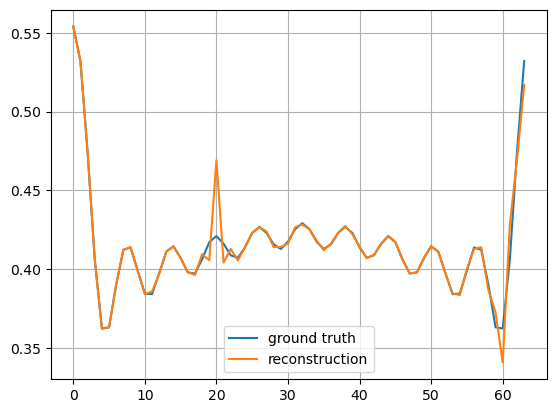

In [12]:
xtrue = Y[8,:] 
sigma = 0

error, zhat = reconstruct(xtrue, A, I, sigma = sigma)
print(error)

domain = np.linspace(0,63,64)
plt.plot(domain, np.abs(xtrue), label = 'ground truth')
plt.plot(domain, np.abs(zhat), label = 'reconstruction')
plt.grid()
plt.legend()

##### Signal filtering

In [13]:
# bandpass signals functions
# source: https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], btype='bandpass', output = 'sos')
    return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    sos = butter_bandpass(lowcut, highcut, fs, order=order)
    y = sosfilt(sos, data)
    return y

def butter_lowpass_filter(data, highcut, fs, order = 5):
    nyq = 0.5*fs
    high = highcut / nyq
    sos = butter(order, high, btype = 'low', output = 'sos')
    #print("i am sos", sos)
    y = sosfilt(sos,data)
    return y

In [14]:
# chebyshev type I filter
def chebyshev_bandpass(lowcut,highcut,fs,order=5,ripple=2):
    nyq = 0.5*fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = cheby1(order, ripple, [low, high], btype = 'bandpass', output='sos')
    return sos

def chebyshev_bandpass_filter(data,lowcut,highcut,fs,order = 5):
    sos = chebyshev_bandpass(lowcut,highcut,fs,order=order)
    y = sosfilt(sos,data)
    return y

In [15]:
# naive filter - very based on the current length of the array and sampling frequency, so would have to be modified for more general cases
def cut_off_lowpass(data, highcut):
    data = np.atleast_2d(data)
    n = data.shape[1] # will not go well if X is higher dim
    k = fftfreq(n,1)
    cut_off = np.where((k < -highcut ) | (k > highcut))[0]
    data_fft = fft(data)
    data_fft[:,cut_off] = 0
    new_data = np.real(ifft(data_fft, axis=1)) # also only works for real data
    return new_data if data.shape[0] > 1 else new_data[0]

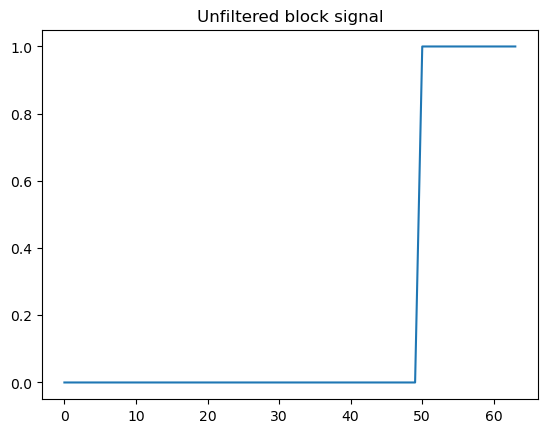

0.21875
[ 0.        0.015625  0.03125   0.046875  0.0625    0.078125  0.09375
  0.109375  0.125     0.140625  0.15625   0.171875  0.1875    0.203125
  0.21875   0.234375  0.25      0.265625  0.28125   0.296875  0.3125
  0.328125  0.34375   0.359375  0.375     0.390625  0.40625   0.421875
  0.4375    0.453125  0.46875   0.484375 -0.5      -0.484375 -0.46875
 -0.453125 -0.4375   -0.421875 -0.40625  -0.390625 -0.375    -0.359375
 -0.34375  -0.328125 -0.3125   -0.296875 -0.28125  -0.265625 -0.25
 -0.234375 -0.21875  -0.203125 -0.1875   -0.171875 -0.15625  -0.140625
 -0.125    -0.109375 -0.09375  -0.078125 -0.0625   -0.046875 -0.03125
 -0.015625]


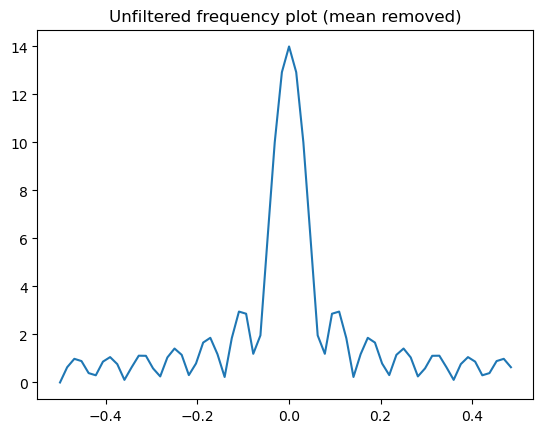

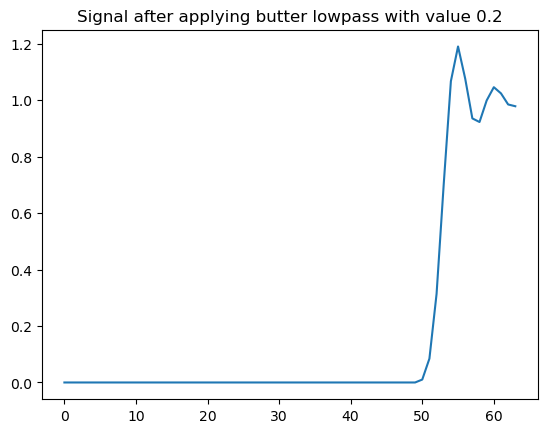

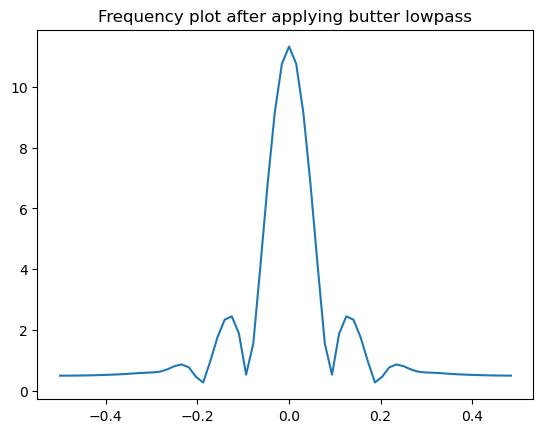

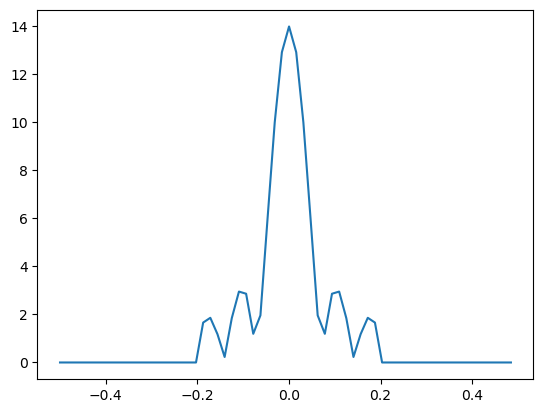

In [16]:
# test the butterworth (bandpass, lowpass) and chebyshev filter: investigate what should be filtered
index = 98
plt.figure()
plt.plot(np.linspace(0,n-1,n), X[index,:])
plt.title("Unfiltered block signal")
plt.show()

mean = np.mean(X[index])
print(mean)
X[index] = X[index] #- mean #note no longer threshold tho
X_fft = fft(X[index])
amplitudes = abs(X_fft)
k = fftfreq(64,1)
print(k)

sorted_indices = np.argsort(k)
k = k[sorted_indices]
amplitudes = amplitudes[sorted_indices]

plt.figure()
plt.plot(k, amplitudes)
plt.title("Unfiltered frequency plot (mean removed)")
plt.show()

low = 0.01
high = 0.2
y = butter_bandpass_filter(X[index],low,high,1, order = 9)
y2 = chebyshev_bandpass_filter(X[index],low,high,1,order=6)
y3 = butter_lowpass_filter(X[index],high,1,order = 6)
y4 = cut_off_lowpass(X[index],0.2)

amplitudes1 = abs(fft(y))
amplitudes1 = amplitudes1[sorted_indices]
amplitudes2 = abs(fft(y2))
amplitudes2 = amplitudes2[sorted_indices]
amplitudes3 = abs(fft(y3))
amplitudes3 = amplitudes3[sorted_indices]
amplitudes4 = abs(fft(y4))
amplitudes4 = amplitudes4[sorted_indices]

# plt.figure()
# plt.plot(np.linspace(0, n-1, n), y)
# plt.title(f"Signal after applying butter bandpass with bandpass [{low}, {high}]")
# plt.show()

plt.figure()
plt.plot(np.linspace(0, n-1, n), y3)
plt.title(f"Signal after applying butter lowpass with value {high}")
plt.show()

# plt.figure()
# plt.plot(k,amplitudes1)
# plt.title("Frequency plot after applying butter bandpass")
# plt.show()

# plt.figure()
# plt.plot(k,amplitudes2)
# plt.title("Frequency plot after applying Chebyshev bandpass")
# plt.show()

plt.figure()
plt.plot(k,amplitudes3)
plt.title("Frequency plot after applying butter lowpass")
plt.show()

plt.figure()
plt.plot(k,amplitudes4)
plt.show()


##### Bandpassed signals

0.14273343028279112


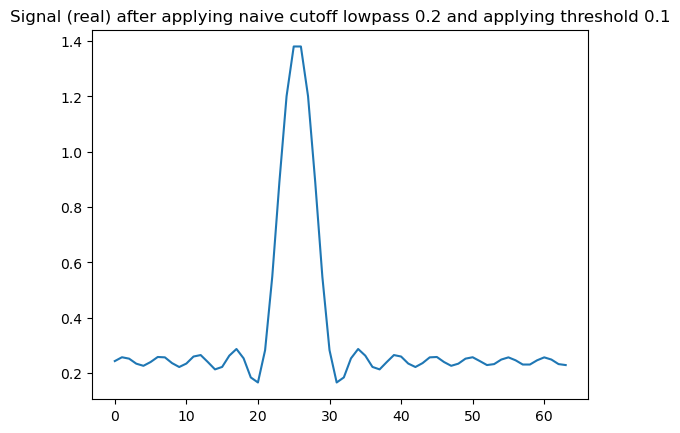

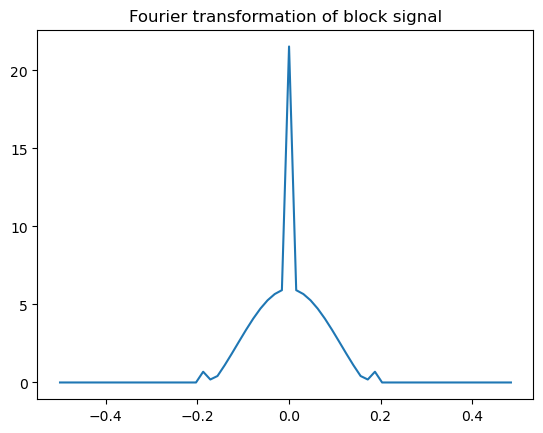

In [17]:
# lowpass works fine without removing means
high = 0.2
order = 6
#X_filtered = butter_lowpass_filter(X,high, 1, order = order)
kndex = 9
X_filtered = cut_off_lowpass(X,high)

# threshold
delta = 0.1
min_value = np.abs(X_filtered.min())
print(min_value)
X_filtered = X_filtered + delta + min_value

# sort k
amplitudes_filtered = abs(fft(X_filtered[kndex,:]))
k = fftfreq(64,1)
sorted_indices = np.argsort(k)
k = k[sorted_indices]
amplitudes_filtered = amplitudes_filtered[sorted_indices]

# example plot
plt.figure()
plt.plot(np.linspace(0, n-1, n), X_filtered[kndex,:])
plt.title(f"Signal (real) after applying naive cutoff lowpass {high} and applying threshold {delta}")
plt.show()

plt.figure()
plt.plot(k,amplitudes_filtered)
plt.title("Fourier transformation of block signal")
plt.show()


##### Test for real block signal

0.46185002263014235


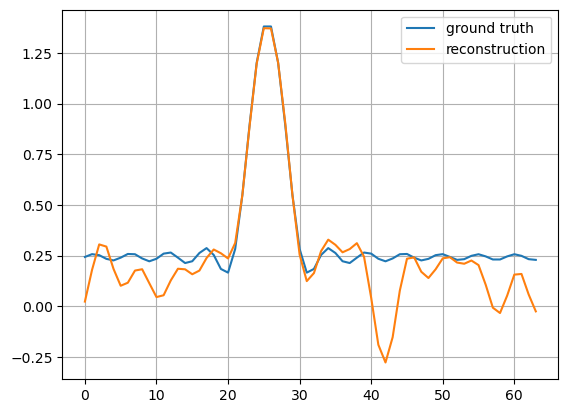

In [23]:
xtrue = X_filtered[9,:] 
sigma = 0.1
#yobs  = np.abs((MF @ xtrue)**2) + sigma*np.random.randn(64*100)
#print(len(yobs))

#val, grad = objective_1D(np.ones(64), yobs, MF)

error, zhat = reconstruct(xtrue, A, G, sigma = sigma)
print(error)

domain = np.linspace(0,63,64)
plt.figure()
plt.plot(domain, np.real(xtrue), label = 'ground truth')
plt.plot(domain, np.real(zhat), label = 'reconstruction')
plt.grid()
plt.legend()

##### Test for complex block signal

0.0003853507305888433


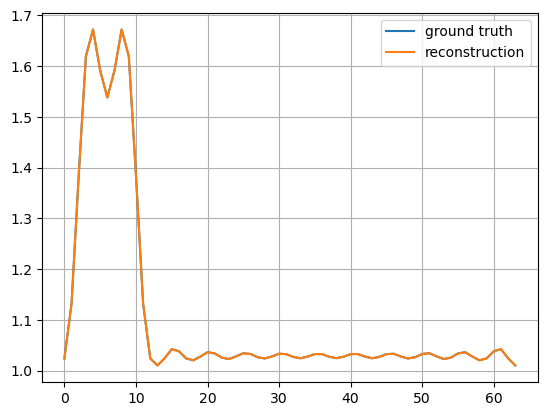

In [24]:
X_complex = np.ones((180,64)) + 1j*X_filtered
xtrue = X_complex[8,:]
sigma = 0

error, zhat = reconstruct(xtrue, A, G, sigma = sigma)
print(error)

domain = np.linspace(0,63,64)
plt.figure()
plt.plot(domain, np.abs(xtrue), label = 'ground truth') 
plt.plot(domain, np.abs(zhat), label = 'reconstruction')
plt.grid()
plt.legend()